# Ziad Al-Ziadi (150010258) - INM460 Computer Vision (2020/21)
### Module leader: Giacomo Tarroni

## Facial Emotion Recognition with SVM and HOG (Histogram of Oriented Gradients)

In the preceding section, we will implement several variations of a Facial Emotion Recognition (FER) solution. It will include a Support Vector Machine (SVM). The SVM will be used with HOG and will make use of the Real-world Affective Faces (RAF) dataset consisting of facial images that depcit emotions that are labeled as:

1: Surprise
2: Fear
3: Disgust
4: Happiness
5: Sadness
6: Anger
7: Neutral

Ultimately, the objective is to have the SVM accurately predict the emotions in unseen images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
from skimage import exposure
from skimage.feature import hog
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.svm import SVC
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from skimage.exposure import equalize_hist, equalize_adapthist


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
zip_path = "/content/drive/MyDrive/CV_Submission/CW_Dataset.zip"
!cp "{zip_path}" .
!yes|unzip -q CW_Dataset.zip

replace test/test_0288_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0828_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1505_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0317_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1055_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0647_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2986_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1923_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0591_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2326_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1383_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2676_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_3064_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2819_aligned.jpg? [y

In [ ]:
# Creating the test and trian path

train_image_path = "/content/train"
test_image_path = "/content/test"

train_txt = "/content/labels/list_label_train.txt"
test_txt = "/content/labels/list_label_test.txt"

# Creating a dataframe from our label txt files

colnames = ["Image_id", "Label"]
train_lab = pd.read_csv(train_txt, names = colnames, header = None, delim_whitespace = True)
test_lab = pd.read_csv(test_txt, names = colnames, header = None, delim_whitespace = True)

In [ ]:
# Here, I'm cleaning the label string to isolate the label value

train_lab["Image_id"] = train_lab["Image_id"].apply(lambda i: i[:-4])
test_lab["Image_id"] = test_lab["Image_id"].apply(lambda i: i[:-4])

# I append the string "_aligned.jpg" so that it matches our image names

train_lab["Image_id"] = train_lab["Image_id"] + "_aligned.jpg"
test_lab["Image_id"] = test_lab["Image_id"] + "_aligned.jpg"

# Here, I carry out a little bit of renidexing: note I have to +1 after to maintain correct label value

train_lab["Label"] = train_lab["Label"].apply(lambda i: i - 1)
train_lab["Label"] = train_lab["Label"].apply(lambda i: i + 1)

test_lab["Label"] = test_lab["Label"].apply(lambda i: i - 1)
test_lab["Label"] = test_lab["Label"].apply(lambda i: i + 1)

In [ ]:
#This function takes a dataframe and applies the HOG descriptor

def hog_des(data_frame):

  hog_img = []
  labels = []

  for i, row in data_frame.iterrows():
    img_path = "/content/train/"
    img_name = row[0]
    lbl = row[1]

    img_path += str(img_name)
    img = cv2.imread(img_path)
    hog_des = hog(img, orientations = 8, pixels_per_cell = (14, 14),
                  cells_per_block = (1,1), visualize = False)
    # kp, des = hog.detectAndCompute(img, None)
    # kp, des = orb.compute(img, kp)
    if hog_des is not None:
      hog_img.append(hog_des)
      labels.append(lbl)
  hog_array = np.vstack(hog_img)

  return hog_array, labels

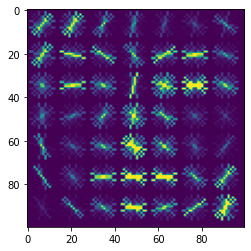

(<matplotlib.image.AxesImage at 0x7f68c3a58c90>, None)

In [ ]:
for i, row in train_lab.iterrows():
  img_path = "/content/train/"
  img_name = row[0]

  img_path += str(img_name)
  img = cv2.imread(img_path)
  _, hog_img= hog(img, orientations = 8, pixels_per_cell = (14, 14),
                  cells_per_block = (1,1), visualize = True)
  HOG_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))

plt.imshow(HOG_image_rescaled),plt.show()

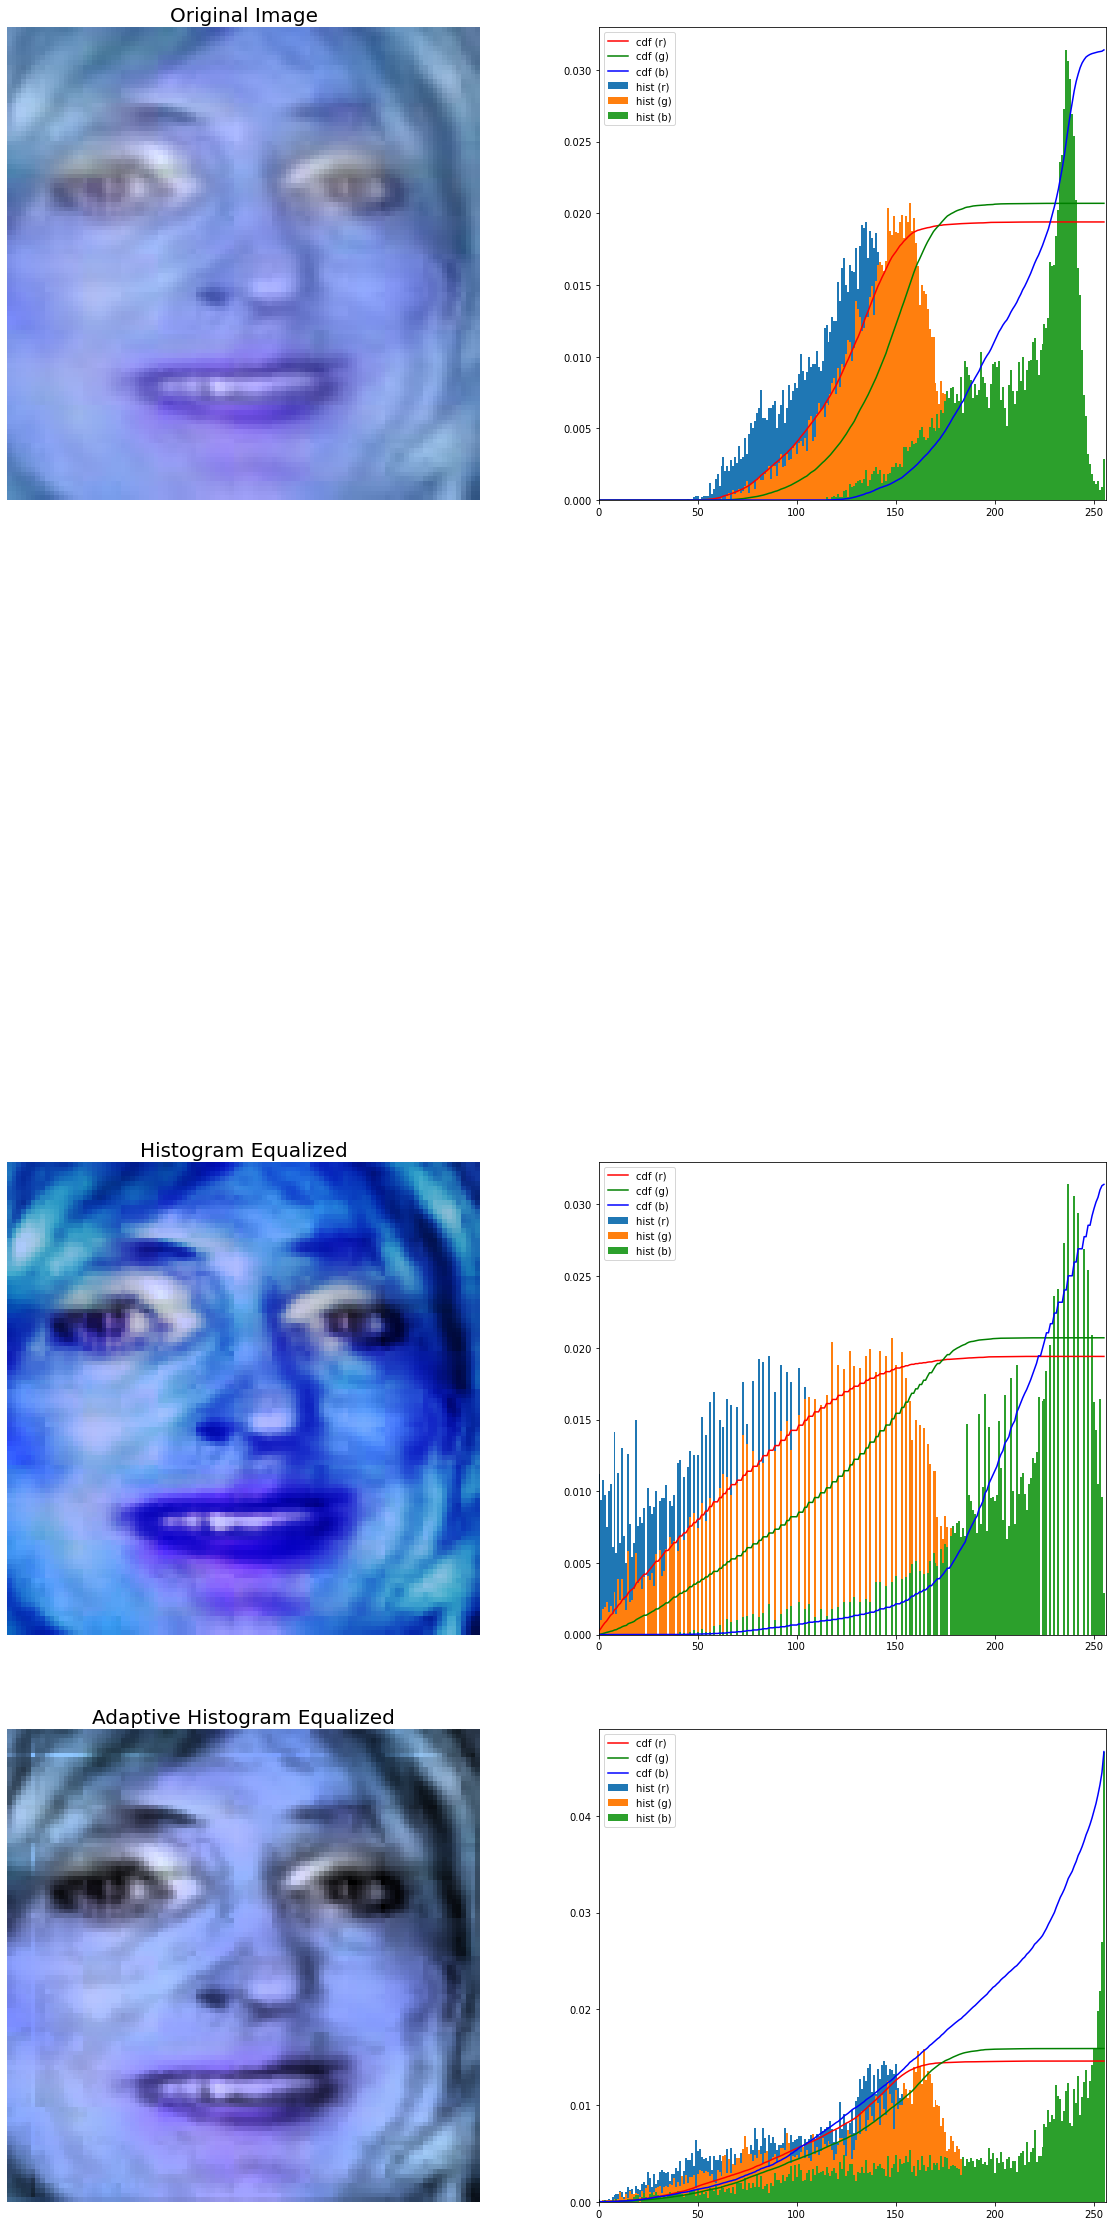

In [ ]:
# Here, we plot a random chosen coloured image to visualise it as a histogram.
# Although not necessary, it provides a better understanding of how HOG makes 
# use of histograms in an image

img = cv2.imread("/content/train/train_00074_aligned.jpg")

plt.figure(figsize=(20,40))

def plot_image(image, title):
    plt.imshow(image)
    plt.title(title, size=20)
    plt.axis('off')
    
def plot_hist(img):
    colors = ['r', 'g', 'b']
    cdf = np.zeros((256,3))
    for i in range(3):
        hist, bins = np.histogram(img[...,i].flatten(),256,[0,256], normed=True)
        cdf[...,i] = hist.cumsum()
        cdf_normalized = cdf[...,i] * hist.max() / cdf.max()
        plt.plot(cdf_normalized, color = colors[i], label='cdf ({})'.format(colors[i]))
        binWidth = bins[1] - bins[0]
        plt.bar(bins[:-1], hist*binWidth, binWidth, label='hist ({})'.format(colors[i]))
        plt.xlim([0,256])
    plt.legend(loc = 'upper left')
    return cdf

plt.subplot(421), plot_image(img, 'Original Image')
plt.subplot(422) 
cdf = plot_hist(img)

img2 = np.copy(img)
for i in range(3):
    cdf_m = np.ma.masked_equal(cdf[...,i],0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf2 = np.ma.filled(cdf_m,0).astype('uint8')
    img2[...,i] = cdf2[img[...,i]]

equ = (255*equalize_hist(img)).astype(np.uint8)
plt.subplot(425), plot_image(equ, 'Histogram Equalized')
plt.subplot(426), plot_hist(equ)


equ = (255*equalize_adapthist(img)).astype(np.uint8)
plt.subplot(427), plot_image(equ, 'Adaptive Histogram Equalized')
plt.subplot(428), plot_hist(equ)
plt.show()

In [ ]:
# Applying HOG to our training set dataframe

hog_train, hog_train_lab = hog_des(train_lab)
X_train, _, y_train, _ = train_test_split(hog_train, hog_train_lab, test_size = 0.1, shuffle=True)

In [ ]:
#Initialising our first SVM 
clf = svm.SVC(kernel = "rbf")
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Once our SVM has been trained on our training set, we can evaluate on our test

#Reading in test data with the same as function as before but with test path instead

def hog_des_test(data_frame):

  hog_img = []
  labels = []

  for i, row in data_frame.iterrows():
    img_path = "/content/test/"
    img_name = row[0]
    lbl = row[1]

    img_path += str(img_name)
    img = cv2.imread(img_path)
    hog_des = hog(img, orientations = 8, pixels_per_cell = (14, 14),
                  cells_per_block = (1,1), visualize = False)
    # kp, des = hog.detectAndCompute(img, None)
    # kp, des = orb.compute(img, kp)
    if hog_des is not None:
      hog_img.append(hog_des)
      labels.append(lbl)
  hog_array = np.vstack(hog_img)

  return hog_array, labels

hog_test, hog_test_lab = hog_des_test(test_lab)

_, X_test, _, y_test = train_test_split(hog_test, hog_test_lab, test_size = .99, shuffle=True)

In [ ]:
#Prediciting on test data

clf_pred = clf.predict(X_test).tolist()

In [ ]:
print(f"""Classification report for classifier {clf}:
      {metrics.classification_report(y_test, clf_pred)}\n""")

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
                    precision    recall  f1-score   support

           1       0.58      0.49      0.53       325
           2       0.88      0.20      0.33        74
           3       0.54      0.08      0.14       158
           4       0.76      0.89      0.82      1174
           5       0.55      0.45      0.50       475
           6       0.63      0.40      0.49       159
           7       0.58      0.74      0.65       673

    accuracy                           0.66      3038
   macro avg       0.65      0.46      0.49      3038
weighted avg       0.65      0.66      0.64      3038




##### We can see that our SVM used with HOG has performed the best across all out other SVMs, however an accuracy score of 67% can still be considered poor. We will now conduct a grid search on our SVM to see whether we can derive better parameters to use with our HOG descriptor.

In [ ]:
# Defining the SVM parameters we would like to tune using grid search

svm_params = [
    {"kernel": ["linear", "poly", "rbf"],
    "C" : [1, 10]}]

In [ ]:
# The scores our SVM will use

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), svm_params, scoring='%s_macro' % score,  cv =2, n_jobs = -1
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on training set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on training set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Classification report for Train set:")
    print()
    y_true_train, y_pred_train = y_train, clf.predict(X_train)
    print(classification_report(y_true_train, y_pred_train))
    print()

    print("Classification report for Test set:")
    print()
    y_test_, y_pred_test = y_test, clf.predict(X_test)
    print(classification_report(y_test_, y_pred_test))
    print()

# Tuning hyper-parameters for recall

Best parameters set found on training set:

{'C': 10, 'kernel': 'rbf'}

Grid scores on training set:

0.423 (+/-0.001) for {'C': 1, 'kernel': 'linear'}
0.443 (+/-0.003) for {'C': 1, 'kernel': 'poly'}
0.424 (+/-0.001) for {'C': 1, 'kernel': 'rbf'}
0.404 (+/-0.004) for {'C': 10, 'kernel': 'linear'}
0.443 (+/-0.001) for {'C': 10, 'kernel': 'poly'}
0.470 (+/-0.009) for {'C': 10, 'kernel': 'rbf'}

Classification report for Train set:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1149
           2       1.00      1.00      1.00       265
           3       1.00      1.00      1.00       653
           4       1.00      1.00      1.00      4278
           5       1.00      1.00      1.00      1789
           6       1.00      1.00      1.00       634
           7       1.00      1.00      1.00      2275

    accuracy                           1.00     11043
   macro avg       1.00      1.00      1

We can see that the SVM used with a HOG descriptor has out performed the other SVM models using ORB and SIFT.

In [ ]:
import pickle

with open("hog_svm.pkl", "wb") as hog_svm:
    pickle.dump(clf, hog_svm)